# 3. Multi-class Vnet on BV

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from dataset import *
from vnet import *
from training import *
from niiutility import show_image, show_batch_image

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3.1 Setup Torch Global Variable, load memory map 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, sampler, SubsetRandomSampler
from torchvision import transforms, utils

import torch.nn.functional as F  # useful stateless functions
import torchvision.transforms as T

#------------------------------- GLOBAL VARIABLES -------------------------------------#

USE_GPU = True
BATCH_SIZE = 2
NUM_WORKERS = 4
NUM_TRAIN = 84
LEARNING_RATE = 1e-3

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('using GPU for training')
else:
    device = torch.device('cpu')

In [8]:
#-------------------------LOAD THE DATA SET-------------------------------------------#

data_index = np.arange(107)
data_index = np.delete(data_index, 46)
dataset_trans = niiMaskDataset(data_index, 
                         transform=transforms.Compose([
                             downSample(2),
                             RandomFilp(0.5),
                             RandomAffine(15, 5)
                         ])
                     )

#-------------------------CREATE DATA LOADER FOR TRAIN AND VAL------------------------#

data_size = len(dataset_trans)
train_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE, \
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)),\
                    num_workers=NUM_WORKERS)
validation_loader = DataLoader(dataset_trans, batch_size=BATCH_SIZE,
                    sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,data_size)),\
                    num_workers=NUM_WORKERS)

* Print first 4 batch of data

0 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


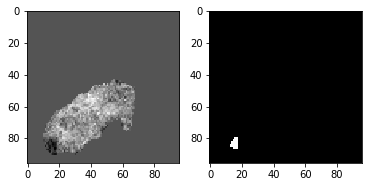

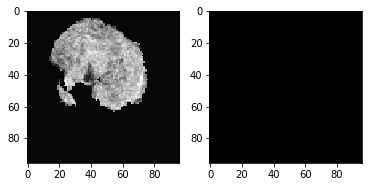

1 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


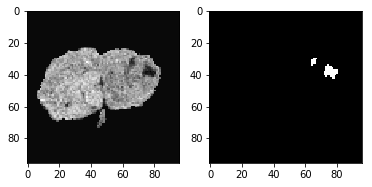

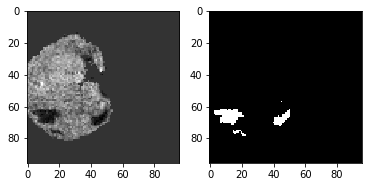

2 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


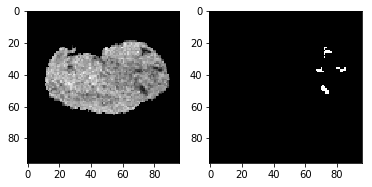

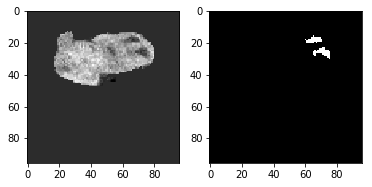

3 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


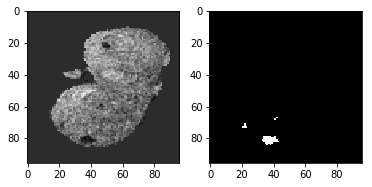

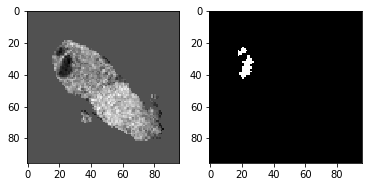

4 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


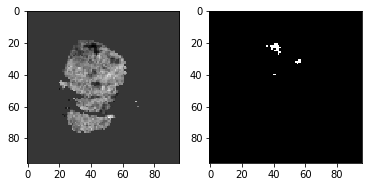

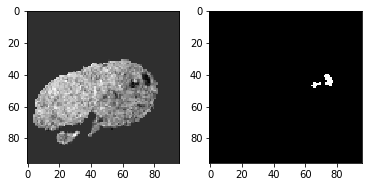

5 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


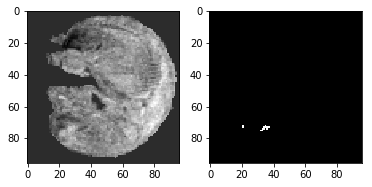

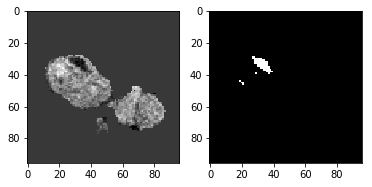

6 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


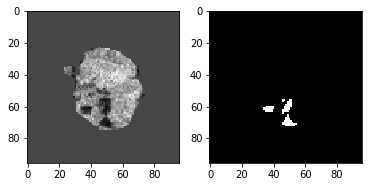

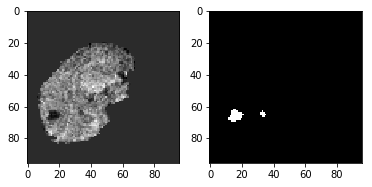

7 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


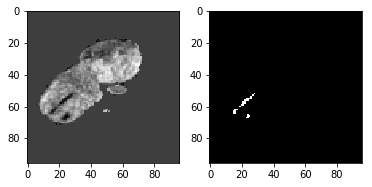

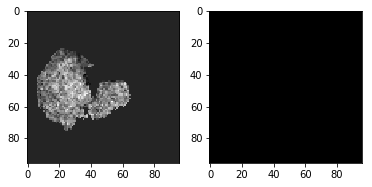

8 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


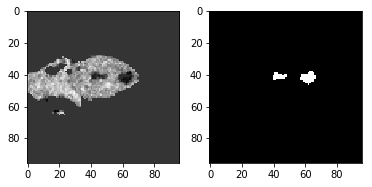

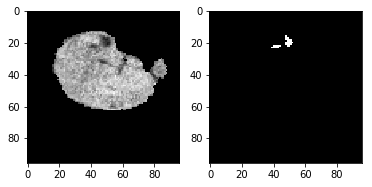

9 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


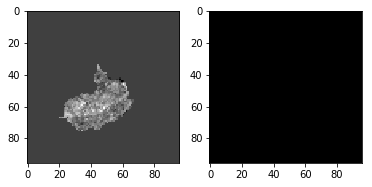

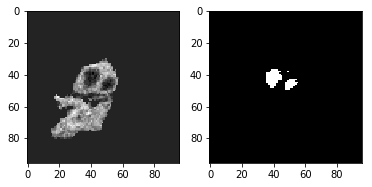

10 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


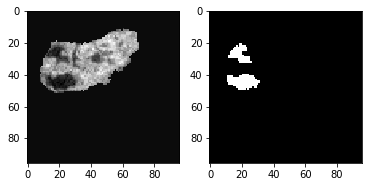

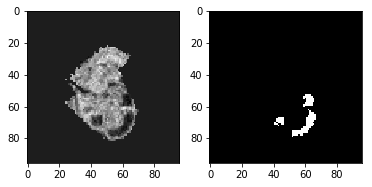

11 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


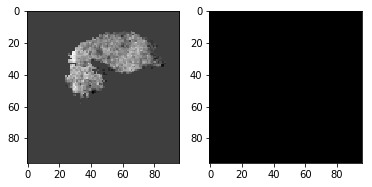

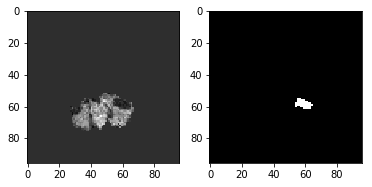

12 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


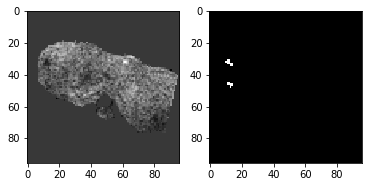

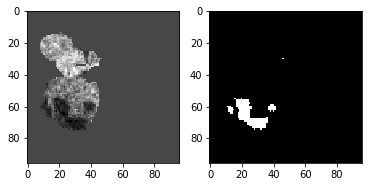

13 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


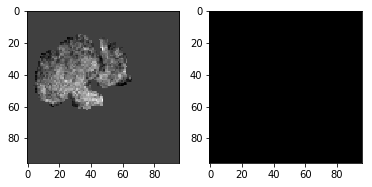

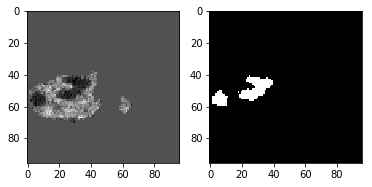

14 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


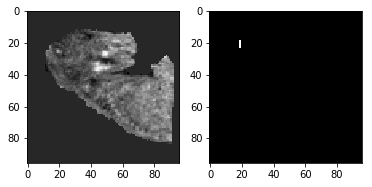

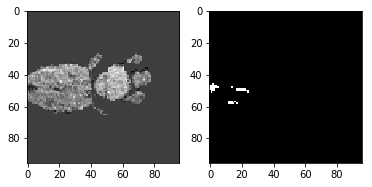

15 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


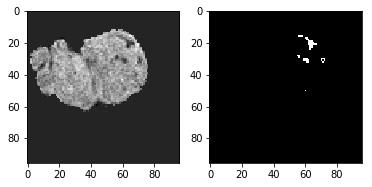

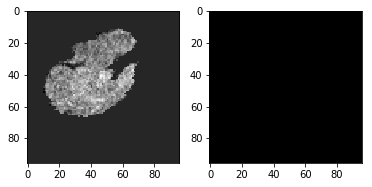

16 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


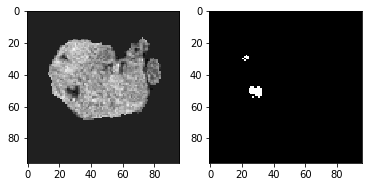

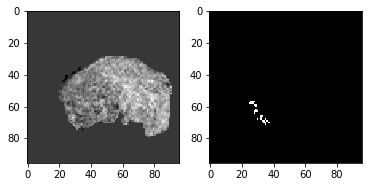

17 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


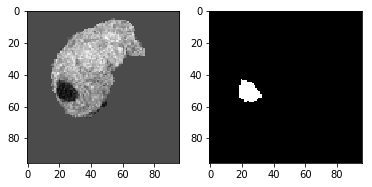

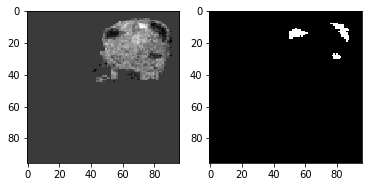

18 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


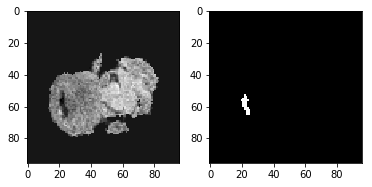

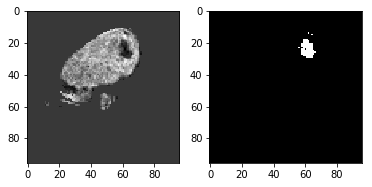

19 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


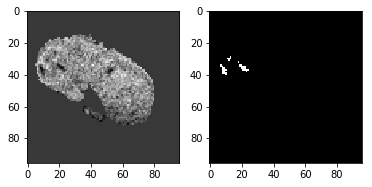

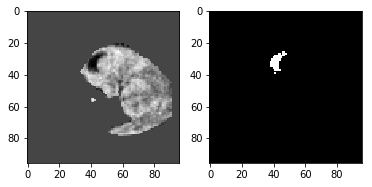

20 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


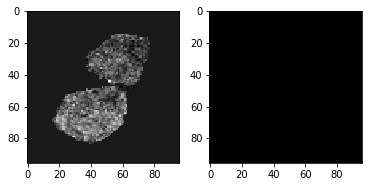

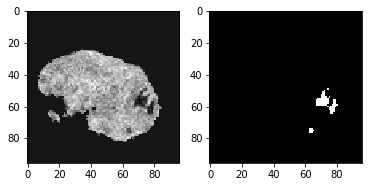

21 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


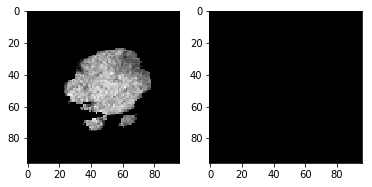

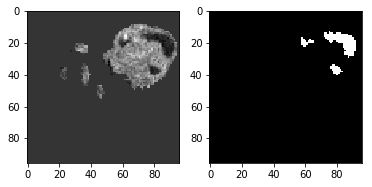

22 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


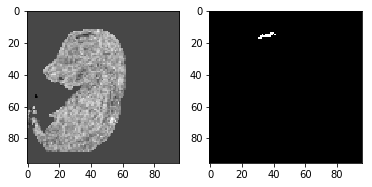

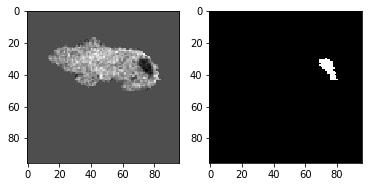

23 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


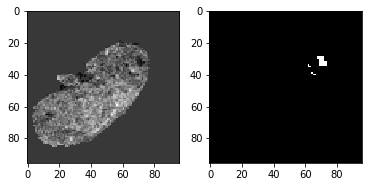

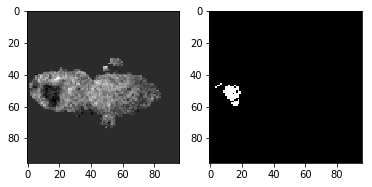

24 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


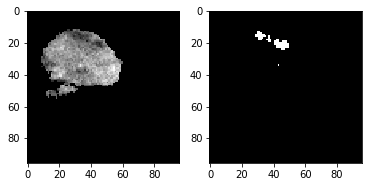

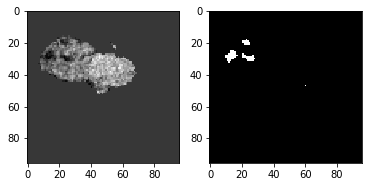

25 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


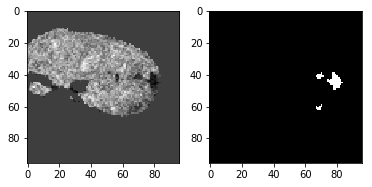

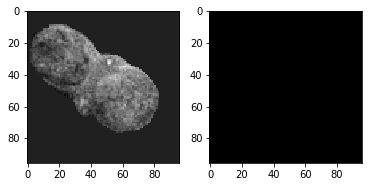

26 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


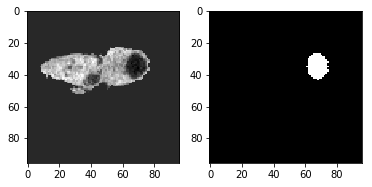

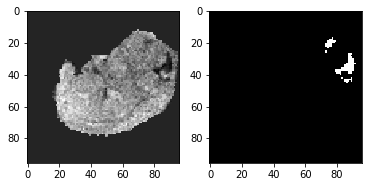

27 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


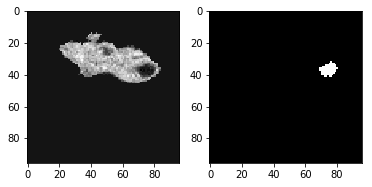

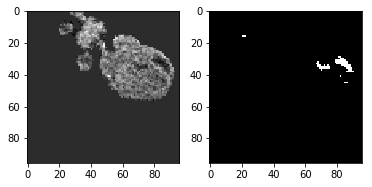

28 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


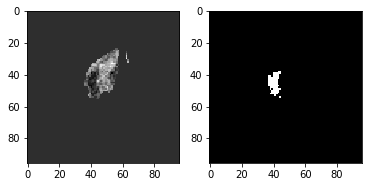

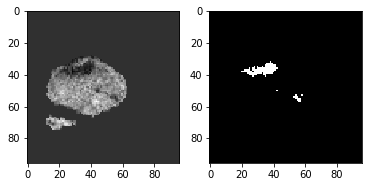

29 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


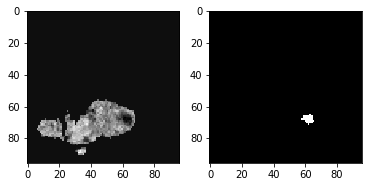

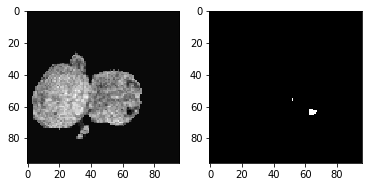

30 torch.Size([2, 1, 64, 96, 96]) torch.Size([2, 1, 64, 96, 96])


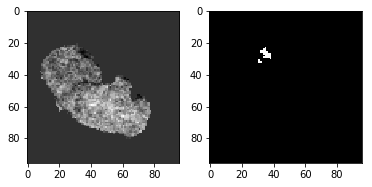

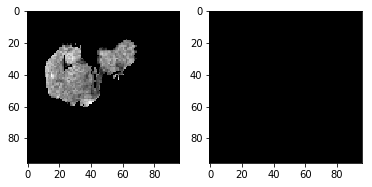

In [9]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), \
          sample_batched['label'].size())
    show_batch_image(sample_batched['image'],sample_batched['label'],BATCH_SIZE, level=2)

    # observe 4th batch and stop.
    if i_batch == 30:
        break

In [ ]:
from vnet import VNet
#-------------------------NEW MODEL INIT WEIGHT--------------------------------------#

model = VNet(classnum=1, slim=False)
model.apply(weights_init)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = optim.SGD (model.parameters(),lr=LEARNING_RATE, momentum=0.99)

In [ ]:
from loss import *

train(model, train_loader, validation_loader, optimizer,\
      device=device, dtype=dtype, lossFun=dice_loss_single, epochs=1500, print_every=100)

In [ ]:
#-------------------------SAVE THE MODEL STATE DICT----------------------------------#
PATH = 'Vet_Mask_class_2'
torch.save(model.state_dict(), PATH)